In [93]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import cv2
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

In [94]:
# todo when running
file = "rtn_experiment_c_cropped"
sigma_tuning = 5 # Ensure that there are minimal breaks and a mostly smoothened control.

In [95]:
cap = cv2.VideoCapture(file + ".mp4")

In [96]:
def printFringes(grayscale_image, slice_sigma = sigma_tuning):
    fringe_count = []
    
    fig = plt.figure(tight_layout=True)
    gs = gridspec.GridSpec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_yticks([])
    ax2.set_xticks([])
    
    ax1.imshow(grayscale_image)
    ax1.set_title("Original image (grayscale)")
    
    # img[img < 10] = 0 # Gets rid of noise, but already done in visibility fn. (which this is called after)
    
    yp, xp = np.where(grayscale_image != 0)
    
    xmax = max(xp)
    xmin = min(xp)

    desired_slice = (xmax - xmin) / 2 + xmin # Centers the slice.
    
    sobely = cv2.Sobel(grayscale_image,cv2.CV_64F,0,1,ksize=5) # Vertical derivative.

    sobely = cv2.blur(sobely,(7,7)) # Smoother peaks
    
    ax2.imshow(sobely, cmap='gray') # Showing derivative
    ax2.plot([desired_slice, desired_slice], [grayscale_image.shape[0], 0], 'r-')
    
    slc = sobely[:, int(desired_slice)]
    slc[slc < 0] = 0
    ax2.set_title("vertical derivative (red -> img. slice)")
    
    slc = gaussian_filter1d(slc, sigma = slice_sigma) # Filtering out noise per sigma, I need to tune.
    
    ax3.plot(slc) 
    peaks = find_peaks(slc)[0] # [0] gives the loc. of the fringes
    
    ax3.plot(peaks, slc[peaks], 'ro')
    ax3.set_title('number of fringes: ' + str(len(peaks)))
    fringe_count.append(len(peaks))
    plt.show()
    return fringe_count

In [97]:
def visibility(grayscale_image, slice_sigma = sigma_tuning):
   #  printFringes(grayscale_image)
    # Plot the frame-by-frame visibility here from testing
    
    yp, xp = np.where(grayscale_image > 10) # Gets rid of noise
    xmid = (xp.max() + xp.min()) // 2
    desired_slice = grayscale_image[:, xmid].astype(float)
    
    smooth_slice = gaussian_filter1d(desired_slice, sigma = slice_sigma) # Noise.
    peaks, _ = find_peaks(smooth_slice, distance = 10)
    troughs, _ = find_peaks(-smooth_slice, distance=10)
    
    if len(peaks) == 0 or len(troughs) == 0:
        return np.nan # There's nothing.
    
    I_max = smooth_slice[peaks].mean()
    I_min = smooth_slice[troughs].mean() # Mean is to even out experimental error.
    visibility = (I_max - I_min) / (I_max + I_min) # Michelson
    
    return visibility

In [98]:
visibility_history = []

In [99]:
# visibility_history = []
# from pathlib import Path
# path = Path(input('Drag‑and‑drop an image here: ').strip())
# img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)

In [100]:
# print(visibility(img))
# print(visibility_history)

In [101]:
print(cap)


< cv2.VideoCapture 0x16c17c050>


In [102]:
while True:
    ok, frame = cap.read()
#    print(ok)
#    print(frame)
    if not ok:
        break
    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    V = visibility(gray_img)
    # printFringes(gray_img)
    visibility_history.append(V)
        


In [103]:
# plt.plot(visibility_history)
# plt.xlabel("Frame #")
# plt.ylabel("Visibility V")
# plt.title("TOM Visibility vs Time")
# plt.show()

In [104]:
print(len(visibility_history))

1205


In [105]:
np.savetxt(file + ".csv", np.array(visibility_history),
           delimiter=",", header="V", comments="")

In [106]:
# RTN Sim.

In [107]:
import random
import pandas as pd
import matplotlib.pyplot as plt

In [108]:
fps = 30
duration_seconds = 45  # match visibility video
sim_len_short = duration_seconds * 1000  # in milliseconds

In [109]:
seed = 0
s = 0.9
updateInterval = 100
sim_len = len(visibility_history) * updateInterval

In [110]:
def rtn_sim(seed, s, interval_ms, sim_len):
    random.seed(seed)
    bit = False
    times, bits = [], []
    for t in range(0, sim_len, interval_ms):
        r = random.random()
        if r > s:
            bit = not bit
        times.append(t)
        bits.append(int(bit))
    return pd.DataFrame({"time": times, "bit": bits})

In [111]:
df_0 = rtn_sim(seed=0, s=s, interval_ms=updateInterval, sim_len=sim_len)
df_1 = rtn_sim(seed=1, s=s, interval_ms=updateInterval, sim_len=sim_len)

In [112]:
# df_merged["time"] = (df_merged["time"] / 1000 * fps).astype(int)

In [113]:
# df_frames = df_merged.groupby("frame").agg({"perturbation_level": "max"}).reset_index()

In [114]:
df_merged = pd.DataFrame({
    "time": df_0["time"],
    "bit_0": df_0["bit"],
    "bit_1": df_1["bit"]
})
df_merged["perturbation_level"] = df_merged["bit_0"] + df_merged["bit_1"]

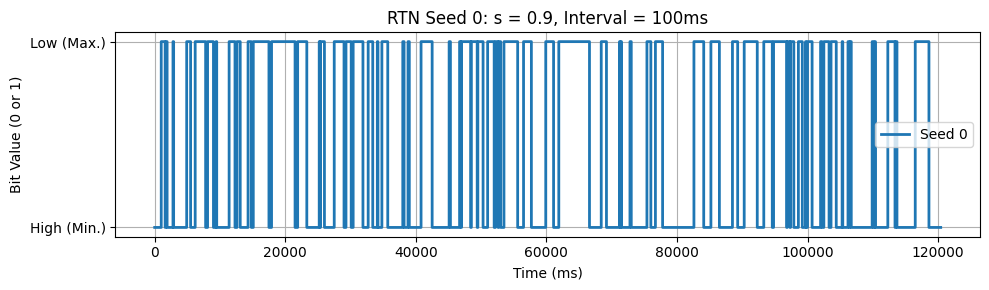

In [115]:
plt.figure(figsize=(10, 3))
plt.step(df_0["time"], df_0["bit"], where='post', label="Seed 0", linewidth=2)
plt.title(f"RTN Seed 0: s = {s}, Interval = {updateInterval}ms")
plt.xlabel("Time (ms)")
plt.ylabel("Bit Value (0 or 1)")
plt.yticks([0, 1], ["High (Min.)", "Low (Max.)"])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

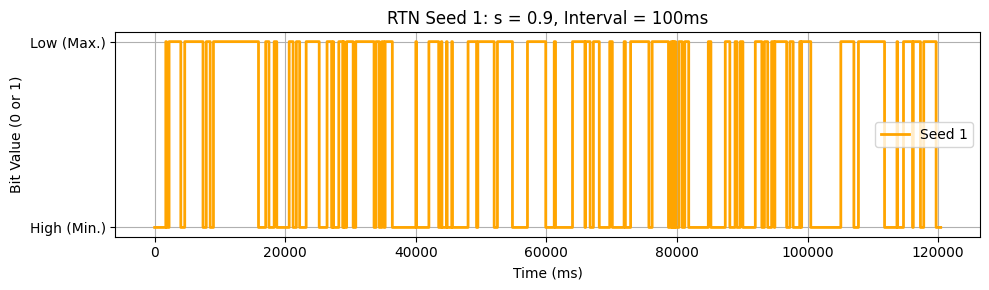

In [116]:
plt.figure(figsize=(10, 3))
plt.step(df_1["time"], df_1["bit"], where='post', label="Seed 1", linewidth=2, color = 'orange')
plt.title(f"RTN Seed 1: s = {s}, Interval = {updateInterval}ms")
plt.xlabel("Time (ms)")
plt.ylabel("Bit Value (0 or 1)")
plt.yticks([0, 1], ["High (Min.)", "Low (Max.)"])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

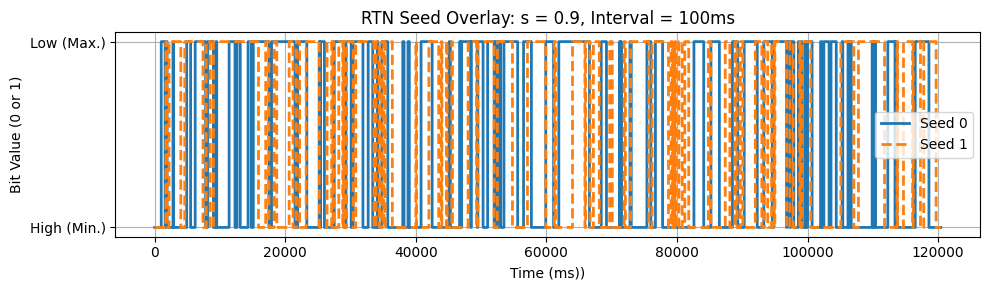

In [117]:
plt.figure(figsize=(10, 3))
plt.step(df_0["time"], df_0["bit"], where='post', label="Seed 0", linewidth=2)
plt.step(df_1["time"], df_1["bit"], where='post', label="Seed 1", linewidth=2, linestyle='--')
plt.title(f"RTN Seed Overlay: s = {s}, Interval = {updateInterval}ms")
plt.xlabel("Time (ms))")
plt.ylabel("Bit Value (0 or 1)")
plt.yticks([0, 1], ["High (Min.)", "Low (Max.)"])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

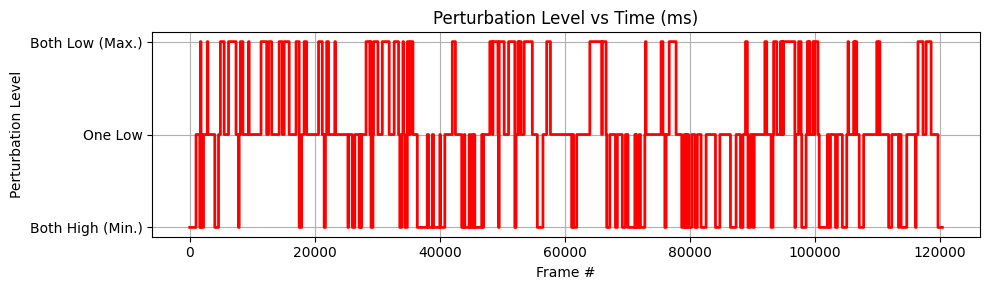

In [118]:
plt.figure(figsize=(10, 3))
plt.step(df_merged["time"], df_merged["perturbation_level"], where='post', linewidth=2, color='red')
plt.title("Perturbation Level vs Time (ms)")
plt.xlabel("Frame #")
plt.ylabel("Perturbation Level")
plt.yticks([0, 1, 2], ["Both High (Min.)", "One Low", "Both Low (Max.)"])
plt.grid(True)
plt.tight_layout()
plt.show()

In [119]:
rtn_padding = pd.DataFrame({
    "time": [0, 5000, 5000, 10000],
    "perturbation_level": [0, 0, 2, 2]
})

df_merged["time"] += 10000
df_merged_padded = pd.concat([rtn_padding, df_merged], ignore_index=True)


In [120]:
visibility_df = pd.read_csv(file + ".csv")
visibility_df["frame"] = visibility_df.index
visibility_df.rename(columns={"V": "visibility"}, inplace=True)
visibility_df["time"] = (visibility_df["frame"] * (1000 / fps)).astype(int)

In [121]:
# filtered_df = visibility_df[
#    (visibility_df["visibility"] < 0.4) &
#    (visibility_df["time"] >= 4000) &
#    (visibility_df["time"] <= 6000)
# ][["time", "visibility"]]

# print(filtered_df)

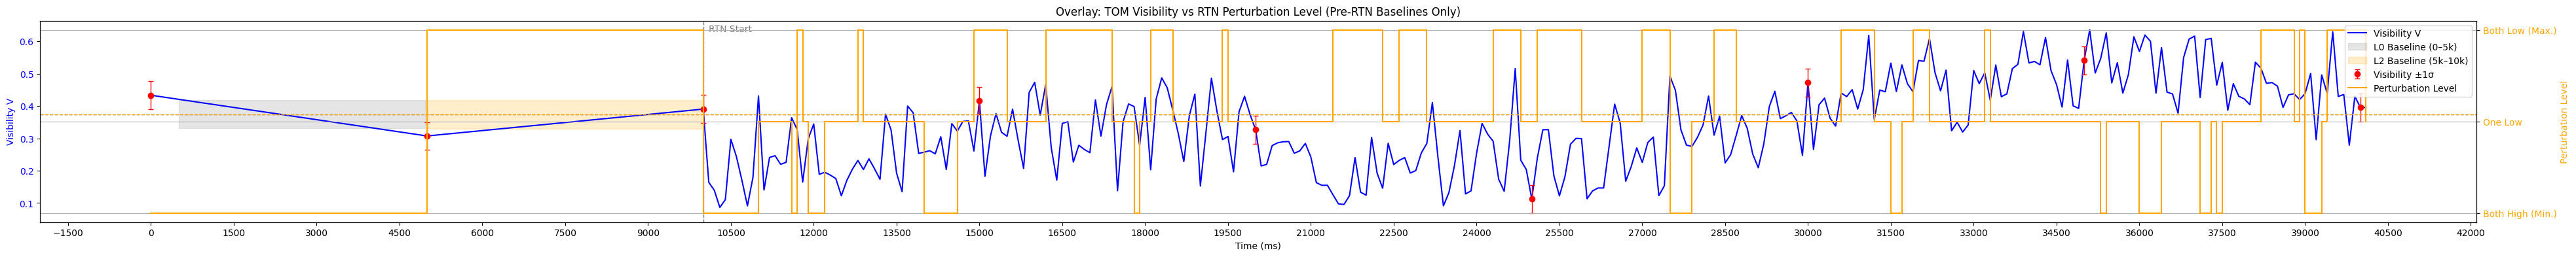

In [122]:
control_0 = visibility_df[(visibility_df["time"] >= 0) & (visibility_df["time"] < 5000)]
mean_0 = control_0["visibility"].mean()
std_0 = control_0["visibility"].std()

control_2 = visibility_df[(visibility_df["time"] >= 5000) & (visibility_df["time"] < 10000)]
mean_2 = control_2["visibility"].mean()
std_2 = control_2["visibility"].std()

sampled_vis = visibility_df[visibility_df["time"] % 5000 == 0].copy()

merged_plot_df = pd.merge(visibility_df, df_merged_padded, on="time", how="inner")

from matplotlib.ticker import MaxNLocator
fig, ax1 = plt.subplots(figsize=(48, 4))

ax1.plot(merged_plot_df["time"], merged_plot_df["visibility"], label="Visibility V", color='blue')
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Visibility V", color='blue')
ax1.xaxis.set_major_locator(MaxNLocator(nbins=40))
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.step(merged_plot_df["time"], merged_plot_df["perturbation_level"], where='post',
         label="Perturbation Level", color='orange')
ax2.set_ylabel("Perturbation Level", color='orange')
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(["Both High (Min.)", "One Low", "Both Low (Max.)"])
ax2.tick_params(axis='y', labelcolor='orange')

ax1.axvline(x=10000, color='gray', linestyle='--', linewidth=1)
ax1.text(10100, ax1.get_ylim()[1]*0.95, 'RTN Start', color='gray')

ax1.errorbar(
    sampled_vis["time"],
    sampled_vis["visibility"],
    yerr=std_0,
    fmt='o',
    color='red',
    ecolor='red',
    elinewidth=1,
    capsize=3,
    label='Visibility ±1σ'
)

time = visibility_df["time"]

ax1.fill_between(
    time,
    mean_0 - std_0,
    mean_0 + std_0,
    where=((time >= 500) & (time < 5000)),
    color='gray',
    alpha=0.2,
    label='L0 Baseline (0–5k)'
)

ax1.fill_between(
    time,
    mean_2 - std_2,
    mean_2 + std_2,
    where=((time >= 5000) & (time < 10000)),
    color='orange',
    alpha=0.2,
    label='L2 Baseline (5k–10k)'
)

ax1.axhline(mean_0, color='gray', linestyle='--', linewidth=1)
ax1.axhline(mean_2, color='orange', linestyle='--', linewidth=1)

plt.title("Overlay: TOM Visibility vs RTN Perturbation Level (Pre-RTN Baselines Only)")
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.grid(True)
plt.show()


perturbation_level
0    0.140332
1    0.129210
2    0.137744
Name: decoherence_from_lvl0, dtype: float64


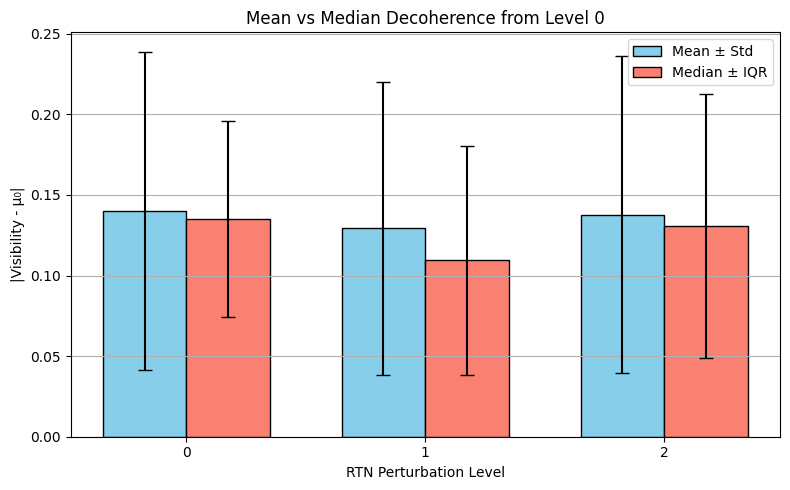

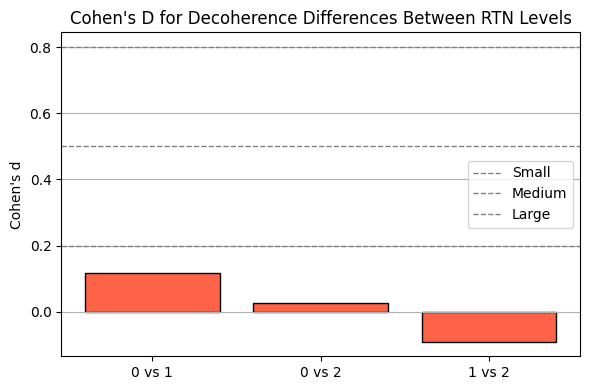

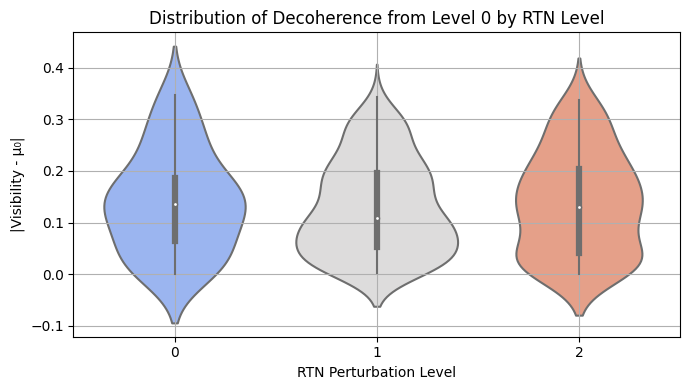

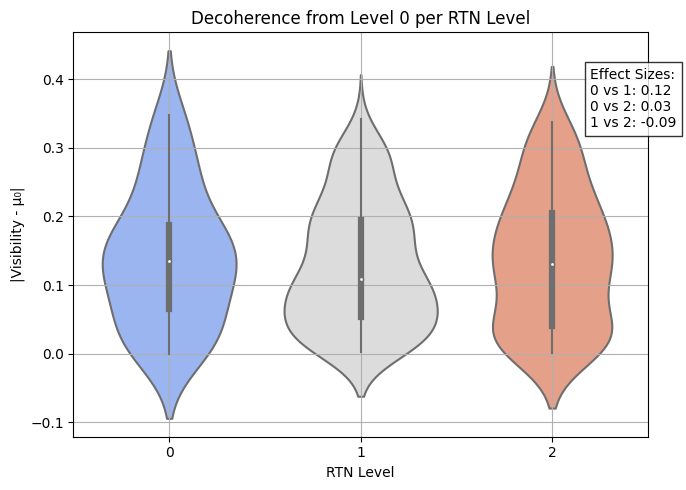

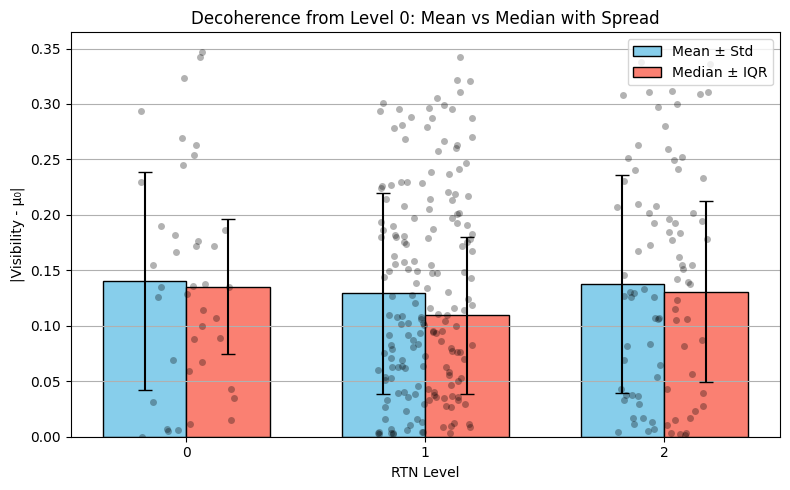

In [123]:
import matplotlib.pyplot as plt

mu_0 = merged_plot_df[(merged_plot_df['time'] >= 0) & (merged_plot_df['time'] < 5000)]['visibility'].mean()
merged_plot_df['decoherence_from_lvl0'] = (merged_plot_df['visibility'] - mu_0).abs()
deviation_by_level = merged_plot_df.groupby('perturbation_level')['decoherence_from_lvl0'].mean()
print(deviation_by_level)

mean_by_level = merged_plot_df.groupby('perturbation_level')['decoherence_from_lvl0'].mean()
std_by_level = merged_plot_df.groupby('perturbation_level')['decoherence_from_lvl0'].std()

median_by_level = merged_plot_df.groupby('perturbation_level')['decoherence_from_lvl0'].median()
q1 = merged_plot_df.groupby('perturbation_level')['decoherence_from_lvl0'].quantile(0.25)
q3 = merged_plot_df.groupby('perturbation_level')['decoherence_from_lvl0'].quantile(0.75)
iqr = q3 - q1

labels = mean_by_level.index.astype(str)
x = np.arange(len(labels))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(x - bar_width/2, mean_by_level.values, yerr=std_by_level.values, 
       width=bar_width, capsize=5, label='Mean ± Std', color='skyblue', edgecolor='black')

ax.bar(x + bar_width/2, median_by_level.values, yerr=iqr.values / 2, 
       width=bar_width, capsize=5, label='Median ± IQR', color='salmon', edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("RTN Perturbation Level")
ax.set_ylabel("|Visibility - μ₀|")
ax.set_title("Mean vs Median Decoherence from Level 0")
ax.legend()
ax.grid(axis='y')
plt.tight_layout()
plt.show()

import numpy as np

def cohens_d(a, b):
    pooled_std = np.sqrt((a.var(ddof=1) + b.var(ddof=1)) / 2)
    return (a.mean() - b.mean()) / pooled_std

lvl0 = merged_plot_df[merged_plot_df['perturbation_level'] == 0]['decoherence_from_lvl0']
lvl1 = merged_plot_df[merged_plot_df['perturbation_level'] == 1]['decoherence_from_lvl0']
lvl2 = merged_plot_df[merged_plot_df['perturbation_level'] == 2]['decoherence_from_lvl0']

d_01 = cohens_d(lvl0, lvl1)
d_02 = cohens_d(lvl0, lvl2)
d_12 = cohens_d(lvl1, lvl2)

effect_sizes = {
    '0 vs 1': d_01,
    '0 vs 2': d_02,
    '1 vs 2': d_12
}

labels = list(effect_sizes.keys())
values = list(effect_sizes.values())

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values, color='tomato', edgecolor='black')
plt.axhline(0.2, color='gray', linestyle='--', linewidth=1, label='Small')
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1, label='Medium')
plt.axhline(0.8, color='gray', linestyle='--', linewidth=1, label='Large')
plt.ylabel("Cohen's d")
plt.title("Cohen's D for Decoherence Differences Between RTN Levels")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

import seaborn as sns

plt.figure(figsize=(7, 4))
sns.violinplot(
    x='perturbation_level', 
    y='decoherence_from_lvl0', 
    data=merged_plot_df, 
    palette='coolwarm'
)
plt.title("Distribution of Decoherence from Level 0 by RTN Level")
plt.xlabel("RTN Perturbation Level")
plt.ylabel("|Visibility - μ₀|")
plt.grid(True)
plt.tight_layout()
plt.show()

import seaborn as sns

plt.figure(figsize=(7, 5))
sns.violinplot(x='perturbation_level', y='decoherence_from_lvl0', data=merged_plot_df, palette='coolwarm')
plt.title("Decoherence from Level 0 per RTN Level")
plt.xlabel("RTN Level")
plt.ylabel("|Visibility - μ₀|")

text = f"Effect Sizes:\n0 vs 1: {d_01:.2f}\n0 vs 2: {d_02:.2f}\n1 vs 2: {d_12:.2f}"
plt.text(2.2, max(merged_plot_df['decoherence_from_lvl0']) * 0.95, text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.grid(True)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

mu_0 = merged_plot_df[(merged_plot_df['time'] >= 0) & (merged_plot_df['time'] < 5000)]['visibility'].mean()
merged_plot_df['decoherence_from_lvl0'] = (merged_plot_df['visibility'] - mu_0).abs()

means = merged_plot_df.groupby('perturbation_level')['decoherence_from_lvl0'].mean()
stds = merged_plot_df.groupby('perturbation_level')['decoherence_from_lvl0'].std()
medians = merged_plot_df.groupby('perturbation_level')['decoherence_from_lvl0'].median()
iqr25 = merged_plot_df.groupby('perturbation_level')['decoherence_from_lvl0'].quantile(0.25)
iqr75 = merged_plot_df.groupby('perturbation_level')['decoherence_from_lvl0'].quantile(0.75)
iqr = iqr75 - iqr25

plt.figure(figsize=(8, 5))

sns.stripplot(x='perturbation_level', y='decoherence_from_lvl0', 
              data=merged_plot_df, color='black', alpha=0.3, jitter=0.2)

bar_width = 0.35
x = np.arange(len(means))

plt.bar(x - bar_width/2, means, yerr=stds, width=bar_width, 
        label='Mean ± Std', color='skyblue', edgecolor='black', capsize=5)

plt.bar(x + bar_width/2, medians, yerr=iqr/2, width=bar_width, 
        label='Median ± IQR', color='salmon', edgecolor='black', capsize=5)

plt.xticks(x, labels=[f'{i}' for i in means.index])
plt.xlabel("RTN Level")
plt.ylabel("|Visibility - μ₀|")
plt.title("Decoherence from Level 0: Mean vs Median with Spread")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
